# Sentiment Analysis Movie Reviews
This project will analyze whether the reviews of a movie is positive and negative based using IMDB reviews.  The goal is to create a model that will analyze a text and will classify it a negative or positive.

## Import necessary dependencies and settings

In [44]:
import os

#Using Matplot to draw the Wordcloud
import matplotlib.pyplot as plt

import pandas as pd
import re
import nltk


## Loading the Data
There are 5 files:
1. Train Texts
2. Train Labels
3. Test Texts
4. Test Labels
5. Dev/Unsupervised

In [45]:
imdb_path = '/Users/jairomelo/Desktop/ML/YORK/ML1010/FinalProject/txtImdb'

# Load the dataset for Training and Test
train_texts = []
train_labels = []
test_texts = []
test_labels = []
for dset in ['train', 'test']:
    for cat in ['pos', 'neg']:
        dset_path = os.path.join(imdb_path, dset, cat)
        for fname in sorted(os.listdir(dset_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(dset_path, fname)) as f:
                    if dset == 'train': train_texts.append(f.read())
                    else: test_texts.append(f.read())
                label = 0 if cat == 'neg' else 1
                if dset == 'train': train_labels.append(label)
                else: test_labels.append(label)


In [46]:
#Development

dev_imdb_path = '/Users/jairomelo/Desktop/ML/YORK/ML1010/FinalProject/txtImdb/train'

dev_texts = []
for fname in sorted(os.listdir(dev_imdb_path)):
    if fname.endswith('.txt'):
        with open(os.path.join(dev_imdb_path, fname)) as f:
            dev_texts.append(f.read())

# Converting to np.array
#dev_texts = np.array(dev_texts)


In [47]:
# Creating the data frame for Training and Test

dict_new = {
    'label': train_labels,
    'text': train_texts    
}


data_train = pd.DataFrame(dict_new)

dict_new = {
    'label': test_labels,
    'text': test_texts
}

data_test = pd.DataFrame(dict_new)



In [48]:
import numpy as np

# Converting to np.array
train = np.array(data_train)
test = np.array(data_test)
dev = np.array(dev_texts)

import pandas as pd 
pd.DataFrame(train).to_csv("train.txt")
pd.DataFrame(test).to_csv("test.txt")
# Converting to np.array
dev = np.array(dev_texts)


In [49]:
frames = [data_train, data_test]
data = pd.concat(frames)

In [50]:
data.sample(10)

,label,text
668,1,I loved this movie and I watch it everyday. I ...
22329,0,It must have been excruciating to attend the d...
9769,1,this is a visual adaptation of manga with very...
5720,1,yeah right. Sammo Hung already acted in the ma...
23176,0,Having watched both the Lion King and Lion Kin...
3851,1,This film was a huge surprise to me while i wa...
18701,0,Shameless waste of my time as a viewer. This i...
180,1,Dr. Ben McKenna (James Stewart) and Jo McKenna...
12377,1,"I understand ""Checking Out"" will likely be rel..."
15238,0,The box to this movie totally misrepresents it...


# 3. Data Cleaning and Data Exploration

Remove HTML characters
Remove all punctuation from words.
Remove all words that are known stop words.
Remove all words less than one character
Stemming:
    Reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language



In [51]:
# remove URL's from train and test
data['clean_text'] = data['text'].apply(lambda x: re.sub(r'http\S+', '', x))
# remove whitespaces
data['clean_text'] = data['clean_text'].apply(lambda x:' '.join(x.split()))


In [52]:
data.sample(10)

,label,text,clean_text
22734,0,Sequels have a nasty habit of being disappoint...,Sequels have a nasty habit of being disappoint...
18366,0,I usually love these movies. Give me a good ol...,I usually love these movies. Give me a good ol...
22845,0,May I start off by saying that Casey Affleck i...,May I start off by saying that Casey Affleck i...
17322,0,what a waste of time! i expected better from c...,what a waste of time! i expected better from c...
21919,0,Since I am required to write minimum of 10 lin...,Since I am required to write minimum of 10 lin...
4722,1,Bromwell High is nothing short of brilliant. E...,Bromwell High is nothing short of brilliant. E...
21664,0,I'm in a film class and i know that i don't kn...,I'm in a film class and i know that i don't kn...
20756,0,"If you're a fan of Mystery Science Theater 3K,...","If you're a fan of Mystery Science Theater 3K,..."
11147,1,"Flynn, known mostly for his swashbuckling role...","Flynn, known mostly for his swashbuckling role..."
22772,0,This is one of those movies that is so bad it ...,This is one of those movies that is so bad it ...


## Feature Engineering

Create a feature for text review length and for the percentage of text that is punctuation

In [53]:
import string

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

data['len'] = data['text'].apply(lambda x: len(x) - x.count(" "))
data['punct%'] = data['text'].apply(lambda x: count_punct(x))


In [54]:
data.sample(10)

,label,text,clean_text,len,punct%
13833,0,"This cheap, grainy-filmed Italian flick is abo...","This cheap, grainy-filmed Italian flick is abo...",1103,4.7
532,1,It may (or may not) be considered interesting ...,It may (or may not) be considered interesting ...,1186,5.7
21794,0,"Okay, so the introduction, with its hokey offe...","Okay, so the introduction, with its hokey offe...",674,5.3
16787,0,"As a kid, I never understood WHY anyone would ...","As a kid, I never understood WHY anyone would ...",906,4.1
11570,1,I have recently seen this production on DVD. I...,I have recently seen this production on DVD. I...,1874,2.9
7903,1,I remember this film as the other person that ...,I remember this film as the other person that ...,877,4.6
10676,1,Pierce Brosnan the newest but no longer James ...,Pierce Brosnan the newest but no longer James ...,525,2.7
17387,0,Being an independent filmmaker and a huge fan ...,Being an independent filmmaker and a huge fan ...,1088,6.5
19092,0,This movie is an insult to ALL submariners. It...,This movie is an insult to ALL submariners. It...,552,4.2
13401,0,That's how I was when I walked (staggered) out...,That's how I was when I walked (staggered) out...,656,9.1


## Evaluate the newly created features

In [55]:
from matplotlib import pyplot

%matplotlib inline

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


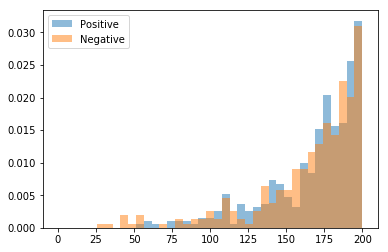

In [57]:
bins = np.linspace(0, 200, 40)

pyplot.hist(data[data['label']==1]['len'], bins, alpha=0.5, normed=True, label='Positive')
pyplot.hist(data[data['label']==0]['len'], bins, alpha=0.5, normed=True, label='Negative')
pyplot.legend(loc='upper left')
pyplot.show()

What we see is the Lenght between positive and negative seems to have some differences, but mainly both move towards the same direcction.

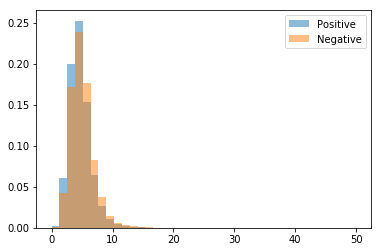

In [58]:
#Potting the number of puntuation
bins = np.linspace(0, 50, 40)

pyplot.hist(data[data['label']==1]['punct%'], bins, alpha=0.5, normed=True, label='Positive')
pyplot.hist(data[data['label']==0]['punct%'], bins, alpha=0.5, normed=True, label='Negative')
pyplot.legend(loc='upper right')
pyplot.show()


The Punctuation feature might not be the best feature as it tends to overlap.

In [59]:
# get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())
    
data['word count'] = data['text'].apply(word_count)
data.sample(10)


,label,text,clean_text,len,punct%,word count
22068,0,See.. I really wanted to enjoy this movie. The...,See.. I really wanted to enjoy this movie. The...,1288,7.5,262
1380,1,"Anyone interested in pop music, and not famili...","Anyone interested in pop music, and not famili...",624,3.5,119
18931,0,Anyone who sees this film will notice that the...,Anyone who sees this film will notice that the...,483,4.1,108
21060,0,"Yes, this review may contain spoilers, but you...","Yes, this review may contain spoilers, but you...",1514,5.5,336
18397,0,"""Air Bud 2: Golden Receiver"" is a very bad reh...","""Air Bud 2: Golden Receiver"" is a very bad reh...",3126,5.2,694
24118,0,This film sold for one-dollar at Wal-Mart on a...,This film sold for one-dollar at Wal-Mart on a...,877,2.2,202
24601,0,I couldn't believe some of the horrible dialog...,I couldn't believe some of the horrible dialog...,1329,6.4,285
23944,0,Largely forgettable tale in which mercenary Ke...,Largely forgettable tale in which mercenary Ke...,1966,4.8,375
24923,0,"Dan Duryea, a perfectly decent B-movie actor w...","Dan Duryea, a perfectly decent B-movie actor w...",511,6.1,105
7883,1,"It was on at 7:30am, too close to school to se...","It was on at 7:30am, too close to school to se...",644,6.4,122


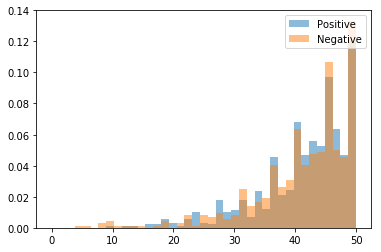

In [60]:
# plot word count distribution for both positive and negative sentiments
bins = np.linspace(0, 50, 40)

pyplot.hist(data[data['label']==1]['word count'], bins, alpha=0.5, normed=True, label='Positive')
pyplot.hist(data[data['label']==0]['word count'], bins, alpha=0.5, normed=True, label='Negative')
pyplot.legend(loc='upper right')
pyplot.show()


## Let's take a quick look at the Words in the Reviews

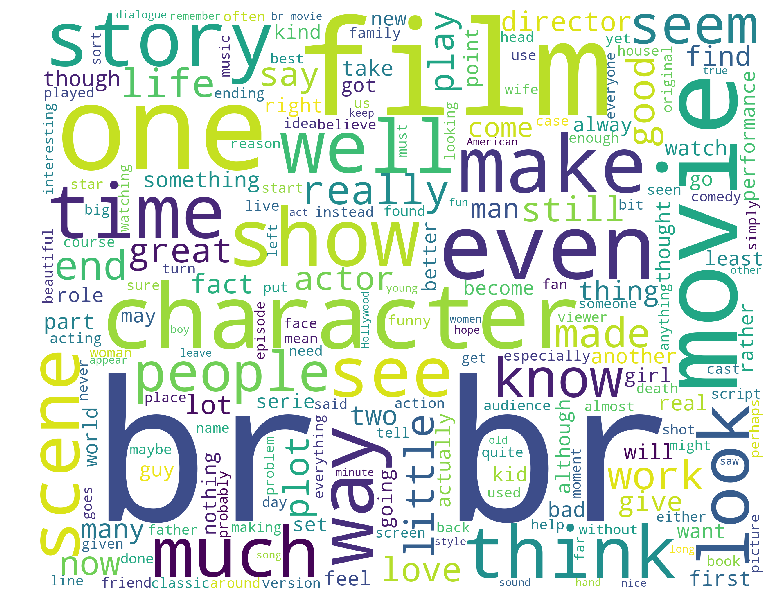

In [38]:
from wordcloud import WordCloud,STOPWORDS

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if not word.startswith(',')
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
list_words = []

list_words = train_texts
    
wordcloud_draw(list_words,'white')


## Lematization
Let's takes into consideration the morphological analysis of the words

In [61]:
import spacy

# import spaCy's language model
nlp = spacy.load('en', disable=['parser', 'ner'])

# function to lemmatize text
def lemmatization(texts):
    output = []
    for i in texts:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output

In [62]:
data['lemmat_text'] = lemmatization(data['clean_text'])

In [63]:
data.sample(10)

,label,text,clean_text,len,punct%,word count,lemmat_text
20927,0,Yet another cookie-cutter movie about a harden...,Yet another cookie-cutter movie about a harden...,388,4.9,88,yet another cookie - cutter movie about a hard...
17820,0,"Ritchie's first two films were snappy, stylish...","Ritchie's first two films were snappy, stylish...",1163,6.8,222,"Ritchie 's first two film be snappy , stylish ..."
17031,0,After receiving a DVD of this with a Sunday ne...,After receiving a DVD of this with a Sunday ne...,899,2.2,193,After receive a dvd of this with a Sunday news...
10531,1,"This is a quite slow paced movie, slowly build...","This is a quite slow paced movie, slowly build...",589,7.5,122,"This be a quite slow paced movie , slowly buil..."
11495,1,Just Go see this movie. It taps into everythin...,Just Go see this movie. It taps into everythin...,653,5.4,143,just go see this movie . -PRON- tap into every...
10906,1,I enjoyed the film and would suggest to anyone...,I enjoyed the film and would suggest to anyone...,641,3.7,139,-PRON- enjoy the film and would suggest to any...
19356,0,Put the blame on executive producer Wes Craven...,Put the blame on executive producer Wes Craven...,724,4.6,141,put the blame on executive producer Wes Craven...
5936,1,Regardless of what personal opinion one may ha...,Regardless of what personal opinion one may ha...,2555,4.0,476,regardless of what personal opinion one may ha...
16501,0,I have no idea how anyone managed to stay awak...,I have no idea how anyone managed to stay awak...,722,6.5,156,-PRON- have no idea how anyone manage to stay ...
23921,0,I suppose that today this film has relevance b...,I suppose that today this film has relevance b...,1838,4.7,400,-PRON- suppose that today this film have relev...


## Tokenizing the clean text

In [64]:
import re

def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

data['text_tokenized'] = data['clean_text'].apply(lambda x: tokenize(x.lower()))

## Removing Stop words

In [65]:
stopword = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

In [66]:
def remove_stopwords(tokenized_list):
    text = [word for word in tokenized_list if word not in stopword]
    return text

data['text_nostop'] = data['text_tokenized'].apply(lambda x: remove_stopwords(x))

In [67]:
data.sample(10)

,label,text,clean_text,len,punct%,word count,lemmat_text,text_tokenized,text_nostop
9574,1,I recently bought this movie for three bucks a...,I recently bought this movie for three bucks a...,2552,6.3,552,-PRON- recently buy this movie for three buck ...,"[i, recently, bought, this, movie, for, three,...","[recently, bought, movie, three, bucks, garage..."
14976,0,A comedy that spoofs the inspirational sports ...,A comedy that spoofs the inspirational sports ...,1472,6.2,322,a comedy that spoof the inspirational sport mo...,"[a, comedy, that, spoofs, the, inspirational, ...","[comedy, spoofs, inspirational, sports, movies..."
1354,1,"/* slight spoilers */<br /><br />Way back, bef...","/* slight spoilers */<br /><br />Way back, bef...",4567,4.6,946,"/ * slight spoiler * /<br /><br />way back , b...","[, slight, spoilers, br, br, way, back, before...","[, slight, spoilers, br, br, way, back, evange..."
24347,0,I wholeheartedly disagree with the other viewe...,I wholeheartedly disagree with the other viewe...,860,5.7,191,-PRON- wholeheartedly disagree with the other ...,"[i, wholeheartedly, disagree, with, the, other...","[wholeheartedly, disagree, viewers, wretched, ..."
17867,0,I don't know what has happened to director Abe...,I don't know what has happened to director Abe...,1024,7.0,232,-PRON- do not know what have happen to directo...,"[i, don, t, know, what, has, happened, to, dir...","[know, happened, director, abel, ferrara, ever..."
19273,0,"As usual, I am making a mad dash to see the mo...","As usual, I am making a mad dash to see the mo...",1228,3.7,291,"As usual , -PRON- be make a mad dash to see th...","[as, usual, i, am, making, a, mad, dash, to, s...","[usual, making, mad, dash, see, movies, watche..."
23304,0,"This ""film,"" and I use that term loosely, remi...","This ""film,"" and I use that term loosely, remi...",1397,9.7,279,"This "" film , "" and -PRON- use that term loose...","[this, film, and, i, use, that, term, loosely,...","[film, use, term, loosely, reminds, first, jok..."
5836,1,"Wow, What a wonderful film-making! Mr. Im has ...","Wow, What a wonderful film-making! Mr. Im has ...",1946,6.5,430,"wow , what a wonderful film - making ! Mr. -PR...","[wow, what, a, wonderful, film, making, mr, im...","[wow, wonderful, film, making, mr, im, done, b..."
1221,1,I caught this movie at the Glenwood Cinemas at...,I caught this movie at the Glenwood Cinemas at...,1148,7.4,257,-PRON- catch this movie at the Glenwood Cinema...,"[i, caught, this, movie, at, the, glenwood, ci...","[caught, movie, glenwood, cinemas, weekend, pa..."
22877,0,"I am partly a fan of Miyazaki's work. I say ""p...","I am partly a fan of Miyazaki's work. I say ""p...",1091,4.5,221,-PRON- be partly a fan of Miyazaki 's work . -...,"[i, am, partly, a, fan, of, miyazaki, s, work,...","[partly, fan, miyazaki, work, say, partly, fil..."


## Evaluate Model Selection
**Cross-validation:** Divide a dataset into k subsets and repeat the holdout method k times where a different subset is used as the holdout set in each iteration.

## Word embedding TF IDF

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[['text_nostop', 'len', 'punct%','word count']], data['label'], test_size=0.2)


In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

def clean_text(text):
    return text

tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['text_nostop'])

tfidf_train = tfidf_vect_fit.transform(X_train['text_nostop'])
tfidf_test = tfidf_vect_fit.transform(X_test['text_nostop'])

X_train_vect = pd.concat([X_train[['len', 'punct%','word count']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['len', 'punct%','word count']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,len,punct%,word count,0,1,2,3,4,5,6,...,92792,92793,92794,92795,92796,92797,92798,92799,92800,92801
0,2385,4.4,515,0.009079,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1710,5.8,333,0.021790,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,553,3.1,114,0.025921,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,875,4.8,185,0.025332,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,510,3.7,110,0.025704,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
from sklearn.decomposition import PCA

# feature extraction
pca = PCA(n_components=5)
fit = pca.fit(X_train_vect)


In [72]:
# summarize components
#print(fit.components_)

print (fit.explained_variance_)
#The pca.explained_variance_ratio_ parameter returns a vector of the variance explained by each dimension
print (fit.explained_variance_ratio_)

#pca.explained_variance_ratio_[i] gives the variance explained solely by the i+1st dimension
#This return a vector x such that x[i] returns the cumulative variance explained by the first i+1 dimensions
print (fit.explained_variance_ratio_.cumsum())


[7.02045584e+05 2.60703929e+02 3.68201484e+00 4.75580045e-03
 3.94995352e-03]
[9.99622178e-01 3.71208702e-04 5.24271326e-06 6.77164519e-09
 5.62422331e-09]
[0.99962218 0.99999339 0.99999863 0.99999864 0.99999864]


## Final evaluation of models

In [74]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.feature_selection import SelectFromModel
from sklearn.datasets import make_classification

import time

In [80]:
rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

start = time.time()
rf_model = rf.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred_rf = rf_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)


In [81]:
precision, recall, fscore, train_support = score(y_test, y_pred_rf, pos_label=1, average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {} / F1 Score: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred_rf==y_test).sum()/len(y_pred_rf), 3), round(fscore, 3)))

Fit time: 375.802 / Predict time: 11.189 ---- Precision: 0.865 / Recall: 0.86 / Accuracy: 0.864 / F1 Score: 0.863


In [82]:
#Feature Importance
sorted(zip(rf_model.feature_importances_, X_train.columns), reverse=True)[0:10]

[(0.0032239412208359213, 'len'),
 (0.002586011500927889, 'punct%'),
 (0.002574772837474503, 'text_nostop'),
 (0.0025358750164764608, 'word count')]

In [83]:
print(confusion_matrix(y_test,y_pred_rf))
print(classification_report(y_test,y_pred_rf))
print(accuracy_score(y_test, y_pred_rf))

[[4394  661]
 [ 694 4251]]
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      5055
           1       0.87      0.86      0.86      4945

   micro avg       0.86      0.86      0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

0.8645


In [85]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, subsample=1)

start = time.time()
gb_model = gb.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred_gb = gb_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)


In [86]:
precision, recall, fscore, train_support = score(y_test, y_pred_gb, pos_label=1, average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {} / F1 Score: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred_gb==y_test).sum()/len(y_pred_gb), 3), round(fscore, 3)))


Fit time: 18183.007 / Predict time: 44.431 ---- Precision: 0.779 / Recall: 0.869 / Accuracy: 0.813 / F1 Score: 0.821


In [87]:
#FTheeature Importance
sorted(zip(gb_model.feature_importances_, X_train.columns), reverse=True)[0:10]

[(0.0002817854324905849, 'punct%'),
 (4.5316218563653224e-05, 'text_nostop'),
 (0.0, 'word count'),
 (0.0, 'len')]

In [88]:
print(confusion_matrix(y_test,y_pred_gb))
print(classification_report(y_test,y_pred_gb))
print(accuracy_score(y_test, y_pred_gb))

[[3836 1219]
 [ 649 4296]]
              precision    recall  f1-score   support

           0       0.86      0.76      0.80      5055
           1       0.78      0.87      0.82      4945

   micro avg       0.81      0.81      0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000

0.8132


In [89]:
#Saving the models for future usage

from sklearn.externals import joblib
joblib.dump(rf_model, 'rf_sentiment_model.pkl')
joblib.dump(gb_model, 'gb_sentiment_model.pkl')

['gb_sentiment_model.pkl']

## Plotting a ROC Curve
ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. The ROC curve shows our model has Skill.
Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. By analogy, Higher the AUC, better the model is at distinguishing between patients with disease and no disease.

In [90]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import auc
#as auc_R
#from sklearn.metrics import auc as uac_G

# predict probabilities of Randomforest
probs_R = rf_model.predict_proba(X_test_vect)
# keep probabilities for the positive outcome only
probs_R = probs_R[:, 1]
# calculate AUC of Randomforest
auc_R = roc_auc_score(y_test, probs_R)
# calculate roc curve
fpr_R, tpr_R, thresholds_R = roc_curve(y_test, probs_R)


# predict probabilities of GradientBoosting
probs_G = gb_model.predict_proba(X_test_vect)
# keep probabilities for the positive outcome only
probs_G = probs_G[:, 1]
# calculate AUC of GradientBoosting
auc_G = roc_auc_score(y_test, probs_G)
fpr_G, tpr_G, thresholds_G = roc_curve(y_test, probs_G)


print('Randomforest AUC: %.3f' % auc_R)
print('GradientBoosting AUC: %.3f' % auc_G)

Randomforest AUC: 0.939
GradientBoosting AUC: 0.902


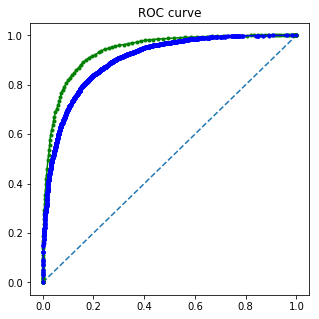

In [95]:
pyplot.figure(figsize=(5,5))
# plot the skill for each Model
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the precision-recall curve for the model
pyplot.title('ROC curve')

pyplot.plot(fpr_R, tpr_R, marker='.',color='green',label='Randomforest')
# plot the precision-recall curve for the model
pyplot.plot(fpr_G, tpr_G, marker='.',color='blue', label='GradientBoosting')
# show the plot
pyplot.show()

## Precision-Recall Curve

In [96]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc

# predict class values
yhat_R = rf_model.predict(X_test_vect)
# calculate precision-recall curve
precision_R, recall_R, thresholds_R = precision_recall_curve(y_test, probs_R)
# calculate F1 score
f1_R = f1_score(y_test, yhat_R)
# calculate precision-recall AUC
auc_R = auc(recall_R, precision_R)
# calculate average precision score
ap_R = average_precision_score(y_test, probs_R)

# predict class values
yhat_G = gb_model.predict(X_test_vect)
# calculate precision-recall curve
precision_G, recall_G, thresholds_G = precision_recall_curve(y_test, probs_G)
# calculate F1 score
f1_G = f1_score(y_test, yhat_G)
# calculate precision-recall AUC
auc_G = auc(recall_G, precision_G)
# calculate average precision score
ap_G = average_precision_score(y_test, probs_G)


Randomforest: f1=0.863 auc=0.933 ap=0.931
GradientBoosting: f1=0.821 auc=0.896 ap=0.896


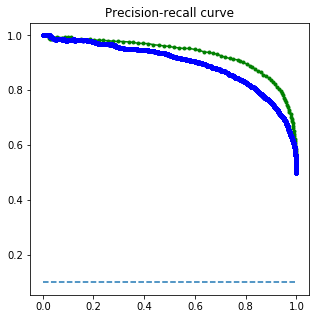

In [99]:
print('Randomforest: f1=%.3f auc=%.3f ap=%.3f' % (f1_R, auc_R, ap_R))
print('GradientBoosting: f1=%.3f auc=%.3f ap=%.3f' % (f1_G, auc_G, ap_G))
# plot the skill for each model
pyplot.figure(figsize=(5,5))
pyplot.plot([0, 1], [0.1, 0.1], linestyle='--')
pyplot.title('Precision-recall curve')
# plot the precision-recall curve for the model
pyplot.plot(recall_R, precision_R, marker='.',color='green',label='Randomforest')
pyplot.plot(recall_G, precision_G, marker='.',color='blue', label='GradientBoosting')
# show the plot
pyplot.show()

# Flair - framework for state-of-the-art Natural Language Processing (NLP)
## Data Preparation

## Loading the Data set from the CSV Files

In [100]:
from flair.data import TaggedCorpus
from flair.data_fetcher import NLPTaskDataFetcher, NLPTask

In [15]:
data_train.sample(10)
corpus: TaggedCorpus = NLPTaskDataFetcher.load_corpus(
                                                              train_file='train.txt',
                                                              test_file='test.txt',
                                                              dev_file='dev.txt')

,text,label
7327,Yesterday my Spanish / Catalan wife and myself...,1
2097,Well-made but basically dreary low-life melodr...,1
21310,"Wow, what a snoozer. Definately one of bacon's...",0
1075,"I knew about but had never seen Grey Gardens, ...",1
12330,When I saw the trailers I just HAD to see the ...,1
10925,Sergeant Ryker is accused of being a traitor d...,1
14826,This movie purports to be a character study of...,0
8730,There's about 25 years worth of inspiration pa...,1
21356,A pointless movie with nothing but gratuitous ...,0
24293,Hybrid starts as water treatment planet securi...,0


In [11]:
# define columns
columns = {0: 'text', 1: 'label'}

# this is the folder in which train, test and dev files reside
data_folder = '/Users/jairomelo/Desktop/ML/YORK/ML1010/FinalProject'
# retrieve corpus using column format, data folder and the names of the train, dev and test files
corpus: TaggedCorpus = NLPTaskDataFetcher.load_column_corpus(data_folder, columns,
                                                              train_file='train.txt',
                                                              test_file='test.txt',
                                                              dev_file='dev.txt')
corpus: TaggedCorpus = NLPTaskDataFetcher.load_corpus(NLPTask.IMDB).downsample(0.1)    
    
stats = corpus.obtain_statistics()
print(stats)

2019-04-19 17:49:47,140 Reading data from /Users/jairomelo/Desktop/ML/YORK/ML1010/FinalProject
2019-04-19 17:49:47,141 Train: /Users/jairomelo/Desktop/ML/YORK/ML1010/FinalProject/train.txt
2019-04-19 17:49:47,142 Dev: /Users/jairomelo/Desktop/ML/YORK/ML1010/FinalProject/dev.txt
2019-04-19 17:49:47,143 Test: /Users/jairomelo/Desktop/ML/YORK/ML1010/FinalProject/test.txt
{
    "TRAIN": {
        "dataset": "TRAIN",
        "total_number_of_documents": 1,
        "number_of_documents_per_class": {},
        "number_of_tokens_per_tag": {},
        "number_of_tokens": {
            "total": 25001,
            "min": 25001,
            "max": 25001,
            "avg": 25001.0
        }
    },
    "TEST": {
        "dataset": "TEST",
        "total_number_of_documents": 1,
        "number_of_documents_per_class": {},
        "number_of_tokens_per_tag": {},
        "number_of_tokens": {
            "total": 25001,
            "min": 25001,
            "max": 25001,
            "avg": 25001.0
  

## Loading the clean data and corpus
This sentence loads the datasets out of the box from Stanford - IMDB Movie review repository
http://ai.stanford.edu/~amaas/data/sentiment/

In [16]:
corpus: TaggedCorpus = NLPTaskDataFetcher.load_corpus(NLPTask.IMDB).downsample(0.1)

2019-04-19 19:32:03,781 Reading data from /Users/jairomelo/.flair/datasets/imdb
2019-04-19 19:32:03,782 Train: /Users/jairomelo/.flair/datasets/imdb/train.txt
2019-04-19 19:32:03,783 Dev: None
2019-04-19 19:32:03,784 Test: /Users/jairomelo/.flair/datasets/imdb/test.txt


## Flair Embeddings

In [17]:
#from flair.embeddings import TokenEmbeddings, WordEmbeddings, StackedEmbeddings
from typing import List

from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer

In [18]:
# Create the label dictionary
label_dict = corpus.make_label_dictionary()

# Make a list of word embeddings
word_embeddings = [WordEmbeddings('glove'),
                   FlairEmbeddings('news-forward'), 
                   FlairEmbeddings('news-backward'),
                  ]

# Initialize document embedding by passing list of word embeddings
document_embeddings: DocumentRNNEmbeddings = DocumentRNNEmbeddings(word_embeddings,
                                                                     hidden_size=512,
                                                                     reproject_words=True,
                                                                     reproject_words_dimension=256,
                                                                     )

# Create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict, multi_label=False)


## Training the Model

In [19]:
import sys

# 6. initialize the text classifier trainer
trainer = ModelTrainer(classifier, corpus)

from flair.training_utils import EvaluationMetric

# 7. start the training

#sending the output of the Training into a File
#sys.stdout = open('Flair_trainer', 'w')

trainer.train('resources/taggers/sentiment',
              EvaluationMetric.MICRO_F1_SCORE,
              learning_rate=0.1,
              mini_batch_size=32,
              anneal_factor=0.5,
              patience=5,
              max_epochs=150)

2019-04-19 19:35:59,484 ----------------------------------------------------------------------------------------------------
2019-04-19 19:35:59,486 Evaluation method: MICRO_F1_SCORE
2019-04-19 19:35:59,487 ----------------------------------------------------------------------------------------------------
2019-04-19 19:38:02,606 epoch 1 - iter 0/71 - loss 0.02117539
2019-04-19 19:51:22,792 epoch 1 - iter 7/71 - loss 0.02140846
2019-04-19 20:02:42,087 epoch 1 - iter 14/71 - loss 0.02163119
2019-04-19 20:13:49,853 epoch 1 - iter 21/71 - loss 0.02175533
2019-04-19 20:25:24,147 epoch 1 - iter 28/71 - loss 0.02171390
2019-04-19 20:40:03,746 epoch 1 - iter 35/71 - loss 0.02166200
2019-04-19 20:51:45,353 epoch 1 - iter 42/71 - loss 0.02165615
2019-04-19 21:03:38,799 epoch 1 - iter 49/71 - loss 0.02160988
2019-04-19 21:16:59,400 epoch 1 - iter 56/71 - loss 0.02170610
2019-04-19 21:28:11,529 epoch 1 - iter 63/71 - loss 0.02175157
2019-04-19 21:41:30,692 epoch 1 - iter 70/71 - loss 0.02200269
2

2019-04-20 02:22:56,028 DEV  : loss 0.02029324 - f-score 0.6360 - acc 0.4663
2019-04-20 02:25:14,877 TEST : loss 0.01998774 - f-score 0.6640 - acc 0.4970
2019-04-20 02:25:14,886 ----------------------------------------------------------------------------------------------------
2019-04-20 02:25:28,712 epoch 8 - iter 0/71 - loss 0.01949101
2019-04-20 02:27:31,865 epoch 8 - iter 7/71 - loss 0.01899572
2019-04-20 02:29:27,337 epoch 8 - iter 14/71 - loss 0.01924101
2019-04-20 02:31:23,728 epoch 8 - iter 21/71 - loss 0.01946135
2019-04-20 02:33:13,738 epoch 8 - iter 28/71 - loss 0.01946138
2019-04-20 02:35:19,870 epoch 8 - iter 35/71 - loss 0.01950986
2019-04-20 02:37:29,349 epoch 8 - iter 42/71 - loss 0.01946825
2019-04-20 02:39:22,022 epoch 8 - iter 49/71 - loss 0.01978264
2019-04-20 02:41:25,217 epoch 8 - iter 56/71 - loss 0.01972495
2019-04-20 02:43:14,301 epoch 8 - iter 63/71 - loss 0.01966360
2019-04-20 02:45:07,122 epoch 8 - iter 70/71 - loss 0.01980592
2019-04-20 02:45:07,151 ------

2019-04-20 04:59:35,719 DEV  : loss 0.02014629 - f-score 0.6920 - acc 0.5291
2019-04-20 05:02:09,721 TEST : loss 0.01953961 - f-score 0.6692 - acc 0.5029
2019-04-20 05:02:09,725 ----------------------------------------------------------------------------------------------------
2019-04-20 05:02:26,400 epoch 15 - iter 0/71 - loss 0.01572281
2019-04-20 05:04:14,616 epoch 15 - iter 7/71 - loss 0.01740196
2019-04-20 05:06:32,757 epoch 15 - iter 14/71 - loss 0.01859128
2019-04-20 05:08:41,394 epoch 15 - iter 21/71 - loss 0.01925362
2019-04-20 05:10:35,257 epoch 15 - iter 28/71 - loss 0.01908651
2019-04-20 05:12:38,154 epoch 15 - iter 35/71 - loss 0.01878520
2019-04-20 05:14:38,317 epoch 15 - iter 42/71 - loss 0.01859052
2019-04-20 05:16:32,103 epoch 15 - iter 49/71 - loss 0.01841112
2019-04-20 05:18:25,737 epoch 15 - iter 56/71 - loss 0.01825461
2019-04-20 05:20:24,120 epoch 15 - iter 63/71 - loss 0.01831584
2019-04-20 05:21:57,527 epoch 15 - iter 70/71 - loss 0.01850938
2019-04-20 05:21:57

2019-04-20 07:35:23,644 EPOCH 21 done: loss 0.0176 - lr 0.1000 - bad epochs 1
2019-04-20 07:35:34,635 DEV  : loss 0.02887706 - f-score 0.5800 - acc 0.4085
2019-04-20 07:37:53,811 TEST : loss 0.03101938 - f-score 0.5236 - acc 0.3546
2019-04-20 07:37:53,814 ----------------------------------------------------------------------------------------------------
2019-04-20 07:38:11,298 epoch 22 - iter 0/71 - loss 0.01802130
2019-04-20 07:40:05,494 epoch 22 - iter 7/71 - loss 0.01804052
2019-04-20 07:42:17,207 epoch 22 - iter 14/71 - loss 0.01767213
2019-04-20 07:44:07,174 epoch 22 - iter 21/71 - loss 0.01715367
2019-04-20 07:46:13,500 epoch 22 - iter 28/71 - loss 0.01720768
2019-04-20 07:48:03,856 epoch 22 - iter 35/71 - loss 0.01715684
2019-04-20 07:49:59,935 epoch 22 - iter 42/71 - loss 0.01693978
2019-04-20 07:52:02,027 epoch 22 - iter 49/71 - loss 0.01706968
2019-04-20 07:54:05,047 epoch 22 - iter 56/71 - loss 0.01715886
2019-04-20 07:55:54,339 epoch 22 - iter 63/71 - loss 0.01711422
2019-

2019-04-20 10:21:22,978 EPOCH 28 done: loss 0.0164 - lr 0.1000 - bad epochs 0
2019-04-20 10:21:38,526 DEV  : loss 0.02139325 - f-score 0.6800 - acc 0.5152
2019-04-20 10:24:35,508 TEST : loss 0.02038307 - f-score 0.6744 - acc 0.5088
2019-04-20 10:24:39,328 ----------------------------------------------------------------------------------------------------
2019-04-20 10:25:05,613 epoch 29 - iter 0/71 - loss 0.01358241
2019-04-20 10:27:24,477 epoch 29 - iter 7/71 - loss 0.01393492
2019-04-20 10:29:33,870 epoch 29 - iter 14/71 - loss 0.01589797
2019-04-20 10:31:51,969 epoch 29 - iter 21/71 - loss 0.01606297
2019-04-20 10:33:51,617 epoch 29 - iter 28/71 - loss 0.01612455
2019-04-20 10:35:55,224 epoch 29 - iter 35/71 - loss 0.01579279
2019-04-20 10:37:59,465 epoch 29 - iter 42/71 - loss 0.01565638
2019-04-20 10:40:01,751 epoch 29 - iter 49/71 - loss 0.01593874
2019-04-20 10:42:05,294 epoch 29 - iter 56/71 - loss 0.01619557
2019-04-20 10:43:51,757 epoch 29 - iter 63/71 - loss 0.01609909
2019-

2019-04-20 13:07:44,020 EPOCH 35 done: loss 0.0152 - lr 0.1000 - bad epochs 2
2019-04-20 13:07:56,918 DEV  : loss 0.02198501 - f-score 0.6520 - acc 0.4837
2019-04-20 13:10:56,839 TEST : loss 0.02331810 - f-score 0.6236 - acc 0.4531
2019-04-20 13:11:06,340 ----------------------------------------------------------------------------------------------------
2019-04-20 13:11:26,104 epoch 36 - iter 0/71 - loss 0.01380247
2019-04-20 13:13:31,544 epoch 36 - iter 7/71 - loss 0.01304039
2019-04-20 13:15:21,583 epoch 36 - iter 14/71 - loss 0.01354884
2019-04-20 13:17:50,451 epoch 36 - iter 21/71 - loss 0.01373733
2019-04-20 13:19:38,766 epoch 36 - iter 28/71 - loss 0.01510264
2019-04-20 13:21:25,221 epoch 36 - iter 35/71 - loss 0.01519278
2019-04-20 13:23:18,593 epoch 36 - iter 42/71 - loss 0.01497754
2019-04-20 13:25:18,033 epoch 36 - iter 49/71 - loss 0.01571293
2019-04-20 13:27:07,211 epoch 36 - iter 56/71 - loss 0.01553666
2019-04-20 13:29:02,986 epoch 36 - iter 63/71 - loss 0.01546072
2019-

2019-04-20 15:43:43,004 EPOCH 42 done: loss 0.0147 - lr 0.1000 - bad epochs 0
2019-04-20 15:43:54,544 DEV  : loss 0.02173554 - f-score 0.6360 - acc 0.4663
2019-04-20 15:46:46,517 TEST : loss 0.02301280 - f-score 0.6348 - acc 0.4650
2019-04-20 15:46:46,526 ----------------------------------------------------------------------------------------------------
2019-04-20 15:47:11,572 epoch 43 - iter 0/71 - loss 0.01277172
2019-04-20 15:49:22,358 epoch 43 - iter 7/71 - loss 0.01258819
2019-04-20 15:51:24,865 epoch 43 - iter 14/71 - loss 0.01270445
2019-04-20 15:53:27,485 epoch 43 - iter 21/71 - loss 0.01223802
2019-04-20 15:55:18,040 epoch 43 - iter 28/71 - loss 0.01282590
2019-04-20 15:57:30,152 epoch 43 - iter 35/71 - loss 0.01285784
2019-04-20 15:59:19,524 epoch 43 - iter 42/71 - loss 0.01311650
2019-04-20 16:01:02,287 epoch 43 - iter 49/71 - loss 0.01335010
2019-04-20 16:02:58,444 epoch 43 - iter 56/71 - loss 0.01366662
2019-04-20 16:04:54,190 epoch 43 - iter 63/71 - loss 0.01368634
2019-

2019-04-20 18:24:34,871 EPOCH 49 done: loss 0.0129 - lr 0.1000 - bad epochs 0
2019-04-20 18:24:49,950 DEV  : loss 0.02552588 - f-score 0.6160 - acc 0.4451
2019-04-20 18:27:27,939 TEST : loss 0.02733948 - f-score 0.6248 - acc 0.4543
2019-04-20 18:27:30,529 ----------------------------------------------------------------------------------------------------
2019-04-20 18:27:52,436 epoch 50 - iter 0/71 - loss 0.01803898
2019-04-20 18:29:47,910 epoch 50 - iter 7/71 - loss 0.01841502
2019-04-20 18:31:48,171 epoch 50 - iter 14/71 - loss 0.01588500
2019-04-20 18:33:47,489 epoch 50 - iter 21/71 - loss 0.01402666
2019-04-20 18:35:47,923 epoch 50 - iter 28/71 - loss 0.01325358
2019-04-20 18:38:02,511 epoch 50 - iter 35/71 - loss 0.01344548
2019-04-20 18:40:08,349 epoch 50 - iter 42/71 - loss 0.01337677
2019-04-20 18:42:08,591 epoch 50 - iter 49/71 - loss 0.01286450
2019-04-20 18:43:44,898 epoch 50 - iter 56/71 - loss 0.01259881
2019-04-20 18:45:44,443 epoch 50 - iter 63/71 - loss 0.01257338
2019-

2019-04-20 21:05:43,660 EPOCH 56 done: loss 0.0110 - lr 0.1000 - bad epochs 1
2019-04-20 21:05:56,612 DEV  : loss 0.02823468 - f-score 0.6080 - acc 0.4368
2019-04-20 21:08:23,317 TEST : loss 0.02980028 - f-score 0.5912 - acc 0.4196
2019-04-20 21:08:26,823 ----------------------------------------------------------------------------------------------------
2019-04-20 21:08:52,504 epoch 57 - iter 0/71 - loss 0.01421328
2019-04-20 21:10:39,219 epoch 57 - iter 7/71 - loss 0.01258204
2019-04-20 21:12:38,878 epoch 57 - iter 14/71 - loss 0.01185806
2019-04-20 21:14:53,449 epoch 57 - iter 21/71 - loss 0.01361977
2019-04-20 21:17:02,153 epoch 57 - iter 28/71 - loss 0.01244209
2019-04-20 21:18:56,586 epoch 57 - iter 35/71 - loss 0.01163747
2019-04-20 21:20:52,568 epoch 57 - iter 42/71 - loss 0.01155227
2019-04-20 21:22:57,198 epoch 57 - iter 49/71 - loss 0.01110505
2019-04-20 21:24:45,248 epoch 57 - iter 56/71 - loss 0.01155158
2019-04-20 21:26:59,925 epoch 57 - iter 63/71 - loss 0.01160721
2019-

2019-04-20 23:48:22,088 EPOCH 63 done: loss 0.0100 - lr 0.1000 - bad epochs 0
2019-04-20 23:48:37,597 DEV  : loss 0.03823593 - f-score 0.5960 - acc 0.4245
2019-04-20 23:51:24,341 TEST : loss 0.04121130 - f-score 0.5884 - acc 0.4168
2019-04-20 23:51:27,009 ----------------------------------------------------------------------------------------------------
2019-04-20 23:51:43,790 epoch 64 - iter 0/71 - loss 0.01703505
2019-04-20 23:53:41,321 epoch 64 - iter 7/71 - loss 0.00928643
2019-04-20 23:55:38,543 epoch 64 - iter 14/71 - loss 0.00849355
2019-04-20 23:57:46,951 epoch 64 - iter 21/71 - loss 0.00911463
2019-04-20 23:59:36,531 epoch 64 - iter 28/71 - loss 0.00902084
2019-04-21 00:01:27,658 epoch 64 - iter 35/71 - loss 0.00898654
2019-04-21 00:03:25,211 epoch 64 - iter 42/71 - loss 0.00922176
2019-04-21 00:05:28,446 epoch 64 - iter 49/71 - loss 0.00932248
2019-04-21 00:07:31,933 epoch 64 - iter 56/71 - loss 0.00934923
2019-04-21 00:09:34,647 epoch 64 - iter 63/71 - loss 0.00951974
2019-

2019-04-21 02:24:09,572 EPOCH 70 done: loss 0.0084 - lr 0.1000 - bad epochs 2
2019-04-21 02:24:20,586 DEV  : loss 0.03361597 - f-score 0.6200 - acc 0.4493
2019-04-21 02:27:07,473 TEST : loss 0.03355063 - f-score 0.6332 - acc 0.4633
2019-04-21 02:27:10,839 ----------------------------------------------------------------------------------------------------
2019-04-21 02:27:30,310 epoch 71 - iter 0/71 - loss 0.00615795
2019-04-21 02:29:37,312 epoch 71 - iter 7/71 - loss 0.00765618
2019-04-21 02:31:32,734 epoch 71 - iter 14/71 - loss 0.00796709
2019-04-21 02:33:27,482 epoch 71 - iter 21/71 - loss 0.00961810
2019-04-21 02:35:11,347 epoch 71 - iter 28/71 - loss 0.01009175
2019-04-21 02:37:16,639 epoch 71 - iter 35/71 - loss 0.00945753
2019-04-21 02:39:05,013 epoch 71 - iter 42/71 - loss 0.00937906
2019-04-21 02:41:17,711 epoch 71 - iter 49/71 - loss 0.00903853
2019-04-21 02:43:02,052 epoch 71 - iter 56/71 - loss 0.00930188
2019-04-21 02:44:53,147 epoch 71 - iter 63/71 - loss 0.00910431
2019-

2019-04-21 04:57:54,915 EPOCH 77 done: loss 0.0059 - lr 0.1000 - bad epochs 1
2019-04-21 04:58:05,924 DEV  : loss 0.04257931 - f-score 0.6040 - acc 0.4327
2019-04-21 05:00:23,306 TEST : loss 0.04256949 - f-score 0.6284 - acc 0.4582
2019-04-21 05:00:26,748 ----------------------------------------------------------------------------------------------------
2019-04-21 05:00:39,537 epoch 78 - iter 0/71 - loss 0.00584540
2019-04-21 05:03:01,461 epoch 78 - iter 7/71 - loss 0.00795662
2019-04-21 05:04:55,980 epoch 78 - iter 14/71 - loss 0.00654126
2019-04-21 05:06:45,094 epoch 78 - iter 21/71 - loss 0.00627126
2019-04-21 05:08:33,430 epoch 78 - iter 28/71 - loss 0.00577746
2019-04-21 05:10:30,551 epoch 78 - iter 35/71 - loss 0.00573833
2019-04-21 05:12:20,045 epoch 78 - iter 42/71 - loss 0.00579424
2019-04-21 05:14:02,942 epoch 78 - iter 49/71 - loss 0.00634323
2019-04-21 05:16:06,428 epoch 78 - iter 56/71 - loss 0.00613047
2019-04-21 05:18:04,375 epoch 78 - iter 63/71 - loss 0.00610705
2019-

2019-04-21 07:34:21,553 EPOCH 84 done: loss 0.0044 - lr 0.1000 - bad epochs 1
2019-04-21 07:34:36,029 DEV  : loss 0.05624340 - f-score 0.5840 - acc 0.4124
2019-04-21 07:37:42,529 TEST : loss 0.05172548 - f-score 0.6456 - acc 0.4767
2019-04-21 07:37:50,124 ----------------------------------------------------------------------------------------------------
2019-04-21 07:38:06,819 epoch 85 - iter 0/71 - loss 0.00481324
2019-04-21 07:40:04,354 epoch 85 - iter 7/71 - loss 0.00325198
2019-04-21 07:41:59,998 epoch 85 - iter 14/71 - loss 0.00391124
2019-04-21 07:44:08,069 epoch 85 - iter 21/71 - loss 0.00360420
2019-04-21 07:46:04,632 epoch 85 - iter 28/71 - loss 0.00363811
2019-04-21 07:48:19,958 epoch 85 - iter 35/71 - loss 0.00392961
2019-04-21 07:50:24,066 epoch 85 - iter 42/71 - loss 0.00433113
2019-04-21 07:52:21,101 epoch 85 - iter 49/71 - loss 0.00448685
2019-04-21 07:54:09,173 epoch 85 - iter 56/71 - loss 0.00446840
2019-04-21 07:56:05,540 epoch 85 - iter 63/71 - loss 0.00458036
2019-

2019-04-21 10:12:51,991 EPOCH 91 done: loss 0.0036 - lr 0.1000 - bad epochs 0
2019-04-21 10:13:04,503 DEV  : loss 0.06144319 - f-score 0.6160 - acc 0.4451
2019-04-21 10:15:26,467 TEST : loss 0.06149784 - f-score 0.6244 - acc 0.4539
2019-04-21 10:15:28,928 ----------------------------------------------------------------------------------------------------
2019-04-21 10:15:44,975 epoch 92 - iter 0/71 - loss 0.00074907
2019-04-21 10:17:42,847 epoch 92 - iter 7/71 - loss 0.00561177
2019-04-21 10:19:50,670 epoch 92 - iter 14/71 - loss 0.00548645
2019-04-21 10:21:49,867 epoch 92 - iter 21/71 - loss 0.00445197
2019-04-21 10:23:33,515 epoch 92 - iter 28/71 - loss 0.00481504
2019-04-21 10:25:39,283 epoch 92 - iter 35/71 - loss 0.00490633
2019-04-21 10:27:32,224 epoch 92 - iter 42/71 - loss 0.00491746
2019-04-21 10:29:04,873 epoch 92 - iter 49/71 - loss 0.00494633
2019-04-21 10:30:48,514 epoch 92 - iter 56/71 - loss 0.00485923
2019-04-21 10:32:50,485 epoch 92 - iter 63/71 - loss 0.00468886
2019-

2019-04-21 12:53:44,284 EPOCH 98 done: loss 0.0041 - lr 0.1000 - bad epochs 0
2019-04-21 12:53:57,470 DEV  : loss 0.06358173 - f-score 0.5960 - acc 0.4245
2019-04-21 12:56:51,112 TEST : loss 0.06186423 - f-score 0.6316 - acc 0.4616
2019-04-21 12:56:51,127 ----------------------------------------------------------------------------------------------------
2019-04-21 12:57:08,239 epoch 99 - iter 0/71 - loss 0.00505008
2019-04-21 12:59:21,143 epoch 99 - iter 7/71 - loss 0.00291558
2019-04-21 13:01:41,119 epoch 99 - iter 14/71 - loss 0.00256411
2019-04-21 13:03:51,019 epoch 99 - iter 21/71 - loss 0.00281994
2019-04-21 13:05:47,328 epoch 99 - iter 28/71 - loss 0.00260409
2019-04-21 13:07:39,992 epoch 99 - iter 35/71 - loss 0.00275275
2019-04-21 13:09:34,848 epoch 99 - iter 42/71 - loss 0.00262246
2019-04-21 13:11:39,651 epoch 99 - iter 49/71 - loss 0.00309137
2019-04-21 13:13:18,524 epoch 99 - iter 56/71 - loss 0.00317530
2019-04-21 13:15:10,876 epoch 99 - iter 63/71 - loss 0.00318627
2019-

2019-04-21 15:55:50,645 ----------------------------------------------------------------------------------------------------
2019-04-21 15:55:50,646 EPOCH 105 done: loss 0.0021 - lr 0.1000 - bad epochs 2
2019-04-21 15:56:10,669 DEV  : loss 0.07119307 - f-score 0.6040 - acc 0.4327
2019-04-21 16:00:37,488 TEST : loss 0.06644686 - f-score 0.6360 - acc 0.4663
2019-04-21 16:00:37,530 ----------------------------------------------------------------------------------------------------
2019-04-21 16:00:53,563 epoch 106 - iter 0/71 - loss 0.00025037
2019-04-21 16:03:15,437 epoch 106 - iter 7/71 - loss 0.00081714
2019-04-21 16:05:47,238 epoch 106 - iter 14/71 - loss 0.00186568
2019-04-21 16:08:16,518 epoch 106 - iter 21/71 - loss 0.00204324
2019-04-21 16:11:07,318 epoch 106 - iter 28/71 - loss 0.00170853
2019-04-21 16:13:52,203 epoch 106 - iter 35/71 - loss 0.00155801
2019-04-21 16:17:04,916 epoch 106 - iter 42/71 - loss 0.00162249
2019-04-21 16:19:27,336 epoch 106 - iter 49/71 - loss 0.00186059

2019-04-21 19:48:22,178 epoch 112 - iter 63/71 - loss 0.00158468
2019-04-21 19:51:11,881 epoch 112 - iter 70/71 - loss 0.00150553
2019-04-21 19:51:11,932 ----------------------------------------------------------------------------------------------------
2019-04-21 19:51:11,932 EPOCH 112 done: loss 0.0015 - lr 0.1000 - bad epochs 4
2019-04-21 19:51:35,825 DEV  : loss 0.08681910 - f-score 0.5760 - acc 0.4045
2019-04-21 19:56:26,416 TEST : loss 0.07846337 - f-score 0.6416 - acc 0.4723
2019-04-21 19:56:45,056 ----------------------------------------------------------------------------------------------------
2019-04-21 19:57:10,063 epoch 113 - iter 0/71 - loss 0.00308318
2019-04-21 19:59:49,963 epoch 113 - iter 7/71 - loss 0.00095900
2019-04-21 20:02:51,691 epoch 113 - iter 14/71 - loss 0.00092539
2019-04-21 20:05:54,278 epoch 113 - iter 21/71 - loss 0.00148013
2019-04-21 20:08:04,801 epoch 113 - iter 28/71 - loss 0.00142015
2019-04-21 20:10:28,743 epoch 113 - iter 35/71 - loss 0.00124240

2019-04-21 23:50:52,590 epoch 119 - iter 49/71 - loss 0.00059305
2019-04-21 23:54:32,127 epoch 119 - iter 56/71 - loss 0.00056215
2019-04-21 23:57:30,797 epoch 119 - iter 63/71 - loss 0.00055410
2019-04-22 00:00:23,040 epoch 119 - iter 70/71 - loss 0.00070148
2019-04-22 00:00:23,090 ----------------------------------------------------------------------------------------------------
2019-04-22 00:00:23,093 EPOCH 119 done: loss 0.0007 - lr 0.1000 - bad epochs 0
2019-04-22 00:00:51,643 DEV  : loss 0.08329722 - f-score 0.6040 - acc 0.4327
2019-04-22 00:06:22,405 TEST : loss 0.07923749 - f-score 0.6376 - acc 0.4680
2019-04-22 00:06:38,187 ----------------------------------------------------------------------------------------------------
2019-04-22 00:06:56,808 epoch 120 - iter 0/71 - loss 0.00066903
2019-04-22 00:09:52,602 epoch 120 - iter 7/71 - loss 0.00095845
2019-04-22 00:12:57,718 epoch 120 - iter 14/71 - loss 0.00133530
2019-04-22 00:15:44,000 epoch 120 - iter 21/71 - loss 0.00104739

2019-04-22 03:50:14,160 epoch 126 - iter 35/71 - loss 0.00100233
2019-04-22 03:53:29,377 epoch 126 - iter 42/71 - loss 0.00086069
2019-04-22 03:56:27,615 epoch 126 - iter 49/71 - loss 0.00080002
2019-04-22 03:59:05,134 epoch 126 - iter 56/71 - loss 0.00081882
2019-04-22 04:04:03,733 epoch 126 - iter 63/71 - loss 0.00094084
2019-04-22 04:06:54,444 epoch 126 - iter 70/71 - loss 0.00098051
2019-04-22 04:06:54,533 ----------------------------------------------------------------------------------------------------
2019-04-22 04:06:54,535 EPOCH 126 done: loss 0.0010 - lr 0.1000 - bad epochs 2
2019-04-22 04:07:22,709 DEV  : loss 0.09332180 - f-score 0.5960 - acc 0.4245
2019-04-22 04:11:44,349 TEST : loss 0.08756530 - f-score 0.6396 - acc 0.4702
2019-04-22 04:11:44,369 ----------------------------------------------------------------------------------------------------
2019-04-22 04:12:03,117 epoch 127 - iter 0/71 - loss 0.00280105
2019-04-22 04:14:40,751 epoch 127 - iter 7/71 - loss 0.00128086

2019-04-22 07:44:33,159 epoch 133 - iter 14/71 - loss 0.00044122
2019-04-22 07:47:17,362 epoch 133 - iter 21/71 - loss 0.00056892
2019-04-22 07:50:30,658 epoch 133 - iter 28/71 - loss 0.00048840
2019-04-22 07:53:27,499 epoch 133 - iter 35/71 - loss 0.00045328
2019-04-22 07:56:19,387 epoch 133 - iter 42/71 - loss 0.00040311
2019-04-22 07:59:36,143 epoch 133 - iter 49/71 - loss 0.00047342
2019-04-22 08:02:26,184 epoch 133 - iter 56/71 - loss 0.00048316
2019-04-22 08:05:45,114 epoch 133 - iter 63/71 - loss 0.00049784
2019-04-22 08:08:43,002 epoch 133 - iter 70/71 - loss 0.00047053
2019-04-22 08:08:43,065 ----------------------------------------------------------------------------------------------------
2019-04-22 08:08:43,067 EPOCH 133 done: loss 0.0005 - lr 0.0500 - bad epochs 0
2019-04-22 08:09:14,209 DEV  : loss 0.09559664 - f-score 0.5960 - acc 0.4245
2019-04-22 08:14:22,618 TEST : loss 0.08935062 - f-score 0.6472 - acc 0.4784
2019-04-22 08:14:22,631 ---------------------------------

2019-04-22 12:07:13,023 epoch 140 - iter 0/71 - loss 0.00004803
2019-04-22 12:10:17,663 epoch 140 - iter 7/71 - loss 0.00019321
2019-04-22 12:13:17,670 epoch 140 - iter 14/71 - loss 0.00018011
2019-04-22 12:16:40,332 epoch 140 - iter 21/71 - loss 0.00034082
2019-04-22 12:19:50,025 epoch 140 - iter 28/71 - loss 0.00035187
2019-04-22 12:23:02,732 epoch 140 - iter 35/71 - loss 0.00030829
2019-04-22 12:26:05,937 epoch 140 - iter 42/71 - loss 0.00029589
2019-04-22 12:29:31,802 epoch 140 - iter 49/71 - loss 0.00028142
2019-04-22 12:32:47,644 epoch 140 - iter 56/71 - loss 0.00028860
2019-04-22 12:36:14,240 epoch 140 - iter 63/71 - loss 0.00027171
2019-04-22 12:39:20,801 epoch 140 - iter 70/71 - loss 0.00028687
2019-04-22 12:39:20,863 ----------------------------------------------------------------------------------------------------
2019-04-22 12:39:20,864 EPOCH 140 done: loss 0.0003 - lr 0.0500 - bad epochs 1
2019-04-22 12:39:46,696 DEV  : loss 0.10181798 - f-score 0.6120 - acc 0.4409
2019-0

2019-04-22 16:36:53,519 ----------------------------------------------------------------------------------------------------
2019-04-22 16:37:19,661 epoch 147 - iter 0/71 - loss 0.00054433
2019-04-22 16:40:40,317 epoch 147 - iter 7/71 - loss 0.00013004
2019-04-22 16:43:41,458 epoch 147 - iter 14/71 - loss 0.00049406
2019-04-22 16:46:56,741 epoch 147 - iter 21/71 - loss 0.00039619
2019-04-22 16:50:00,702 epoch 147 - iter 28/71 - loss 0.00034717
2019-04-22 16:52:58,393 epoch 147 - iter 35/71 - loss 0.00030786
2019-04-22 16:56:03,330 epoch 147 - iter 42/71 - loss 0.00026485
2019-04-22 16:59:28,327 epoch 147 - iter 49/71 - loss 0.00024108
2019-04-22 17:02:43,587 epoch 147 - iter 56/71 - loss 0.00021928
2019-04-22 17:06:00,950 epoch 147 - iter 63/71 - loss 0.00019919
2019-04-22 17:08:47,354 epoch 147 - iter 70/71 - loss 0.00019691
2019-04-22 17:08:47,411 ----------------------------------------------------------------------------------------------------
2019-04-22 17:08:47,412 EPOCH 147 don

{'test_score': 0.6428,
 'dev_score_history': [0.496,
  0.52,
  0.544,
  0.504,
  0.516,
  0.536,
  0.636,
  0.608,
  0.66,
  0.668,
  0.624,
  0.692,
  0.652,
  0.692,
  0.524,
  0.66,
  0.628,
  0.68,
  0.584,
  0.544,
  0.58,
  0.66,
  0.604,
  0.648,
  0.668,
  0.592,
  0.568,
  0.68,
  0.652,
  0.656,
  0.644,
  0.576,
  0.636,
  0.652,
  0.652,
  0.64,
  0.648,
  0.672,
  0.672,
  0.632,
  0.656,
  0.636,
  0.652,
  0.644,
  0.58,
  0.652,
  0.628,
  0.588,
  0.616,
  0.608,
  0.612,
  0.644,
  0.612,
  0.604,
  0.66,
  0.608,
  0.632,
  0.58,
  0.576,
  0.6,
  0.572,
  0.632,
  0.596,
  0.6,
  0.644,
  0.588,
  0.6,
  0.592,
  0.592,
  0.62,
  0.612,
  0.604,
  0.592,
  0.588,
  0.612,
  0.596,
  0.604,
  0.628,
  0.604,
  0.616,
  0.632,
  0.636,
  0.612,
  0.584,
  0.6,
  0.568,
  0.616,
  0.592,
  0.588,
  0.576,
  0.616,
  0.604,
  0.604,
  0.608,
  0.58,
  0.592,
  0.604,
  0.596,
  0.592,
  0.6,
  0.6,
  0.608,
  0.636,
  0.608,
  0.604,
  0.576,
  0.588,
  0.612,
  0.604,


## Plot training curves

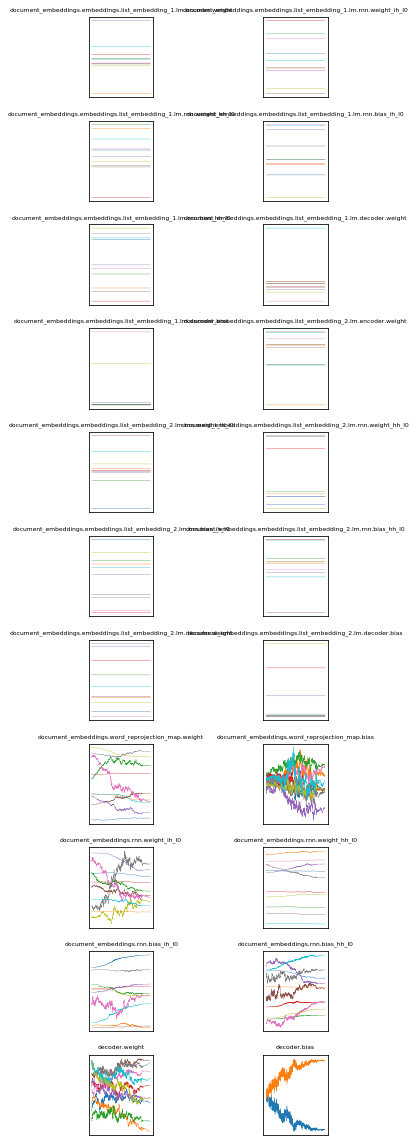

In [71]:
from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_training_curves('resources/taggers/sentiment/loss.tsv')
plotter.plot_weights('resources/taggers/sentiment/weights.txt')

## Using the Model - Running a prediction

In [107]:



#Loading classifier from the recent Trainine.  This line can be ommited if the classifier is already initialized
classifier = TextClassifier.load_from_file('resources/taggers/sentiment/final-model.pt')



2019-04-23 21:23:30,316 loading file resources/taggers/sentiment/final-model.pt
[pos (1.0)]
[Sentence: "I liked French Kiss, Kevin Kline and Meg Ryan delivered an amazing performance; love the story and the connection to grapes and wine in France" - 25 Tokens]


In [108]:
from flair.data import Sentence
# create example sentence
sentence = Sentence('I liked French Kiss, Kevin Kline and Meg Ryan delivered an amazing performance; love the story and the connection to grapes and wine in France')

# predict tags and print
scores = classifier.predict(sentence)
print(sentence.labels)
print(scores)

[pos (1.0)]
[Sentence: "I liked French Kiss, Kevin Kline and Meg Ryan delivered an amazing performance; love the story and the connection to grapes and wine in France" - 25 Tokens]


In [109]:
# create example sentence
sentence = Sentence('I was very disapointed with the episode 1, 2 and 3 of star wars.  Bad script and very regular acting.  I do not recommend it')

# predict tags and print
scores = classifier.predict(sentence)
print(sentence.labels)
print(scores)

[neg (1.0)]
[Sentence: "I was very disapointed with the episode 1, 2 and 3 of star wars. Bad script and very regular acting. I do not recommend it" - 25 Tokens]


In [104]:
#Running a prediction for RandomForest and GradientBoosting
from sklearn.externals import joblib

#Loading Randomforest model
rf_sentiment_model = open('rf_sentiment_model.pkl','rb')
rf_model = joblib.load(rf_sentiment_model)

#Loading GradientBoosting
gb_sentiment_model = open('rf_sentiment_model.pkl','rb')
gb_model = joblib.load(gb_sentiment_model)


In [105]:
stopwords = nltk.corpus.stopwords.words('english')

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

In [106]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract Feature With CountVectorizer
texto = ['I liked French Kiss, Kevin Kline and Meg Ryan delivered an amazing performance; love the story and the connection to grapes and wine in France']

#tfidf_vect = TfidfVectorizer(analyzer=clean_text)
#tfidf_vect_fit = tfidf_vect.fit(texto)

tfidf_text = TfidfVectorizer.transform(texto)


# predict Randomforest
predict_R = rf_model.predict(tfidf_text)
print(predict_R.labels)
print(predict_R)

# predict GradientBoosting
predict_G = gb_model.predict(tfidf_test)
print(predict_G.labels)
print(predict_G)


TypeError: transform() missing 1 required positional argument: 'raw_documents'